# Lab 52087: Inversion on Neural Fields

In this lab, we will explore the concept of inversion and differentiability in neural fields, using images as an example.
In this part, we will explore how to invert a trained neural field (like a PE-MLP or SIREN) that maps from spatial coordinates (x, y) to RGB color values. Specifically, for a given target color, we aim to find the input coordinate that the neural field would map as closely as possible to a tartget (color, patch or something else).

## Task 1:
Inversion on Neural Fields with a Trained (Frozen) Model (use your trained PE-MLP or SIREN from last LAB)

The goal of this task is to perform inversion on a neural field that has already been trained (and is now frozen). 
The idea is to find an input coordinate (x, y) that, when passed through the neural field, produces a given target color.

Step-by-step procedure:

1. Train your neural field model (e.g., SIREN) on the `map-saturation.png` image. 
   After training, visualize the reconstruction to check that the model has learned the mapping correctly.

2. Select a random coordinate (pixel) from the image and use its color as the target color. 
   This will be the reference value we are trying to recover via inversion.

3. Randomly initialize a coordinate (x, y) in the normalized range [-1, 1]. 
   This coordinate is learnable, while the neural field model’s parameters remain fixed.

4. Define an optimization loop to adjust only the (x, y) coordinate:
   - For each iteration, compute the model’s predicted color from the current coordinate.
   - Calculate the loss between the predicted color and the target color (e.g., using MSE).
   - Backpropagate and update only the coordinate to minimize the loss.
   - Ensure the neural field model remains frozen (no parameter updates).

5. Visualize the inversion process:
   - Track and plot the loss over time.
   - Visualize the trajectory of the coordinate in pixel space to see how it moves towards the solution.

6. Experiment with different random initializations of the coordinate, and observe if and how they lead to different local solutions.
   - Discuss any differences or interesting behaviors you find when starting from different points.

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [2]:

from typing import Tuple

def load_image(path: str, resize: Tuple[int, int]=(128, 128)) -> np.ndarray:
    # Load an image from path, resize to the desired resolution and return a normalized
    # numpy array of shape (H, W, 3) with values in [0,1].
    img = Image.open(path).convert('RGB')
    img = img.resize(resize)
    img_np = np.asarray(img, dtype=np.float32) / 255.0
    return img_np


def generate_synthetic_image(resolution: int = 128) -> np.ndarray:
    # Generate a synthetic RGB image using sinusoidal patterns.  This avoids external
    # dependencies and provides a known ground truth with high‑frequency content.
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    xv, yv = np.meshgrid(x, y)
    img = np.zeros((resolution, resolution, 3), dtype=np.float32)
    # Red channel: high‑frequency checkerboard pattern
    img[..., 0] = (np.sin(2 * np.pi * 6 * xv) * np.sin(2 * np.pi * 6 * yv) + 1) / 2
    # Green channel: low‑frequency radial gradient
    r = np.sqrt((xv - 0.5) ** 2 + (yv - 0.5) ** 2)
    img[..., 1] = 1 - r / np.max(r)
    # Blue channel: diagonal stripes
    img[..., 2] = (np.sin(2 * np.pi * 4 * (xv + yv)) + 1) / 2
    return img


def prepare_dataset(img: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
    # Given an image array of shape (H, W, 3), return tensors:
    #  coords: (N, 2) containing (x,y) in [-1,1]
    #  colors: (N, 3) containing RGB in [0,1]
    h, w, c = img.shape
    ys = np.linspace(-1.0, 1.0, h)
    xs = np.linspace(-1.0, 1.0, w)
    xv, yv = np.meshgrid(xs, ys)
    coords = np.stack([xv, yv], axis=-1).reshape(-1, 2).astype(np.float32)
    colors = img.reshape(-1, c).astype(np.float32)
    coords = torch.from_numpy(coords).to(device)
    colors = torch.from_numpy(colors).to(device)
    return coords, colors


In [3]:

class SineLayer(nn.Module):
    # A single fully connected layer with sine activation and specialized initialization
    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 is_first: bool = False, omega_0: float = 30.0):
        super().__init__()
        ###########################################################
        ### TODO: complete the SineLayer class
        ###########################################################
        self.in_features = in_features
        self.bias = bias
        self.is_first = is_first
        self.omega_0 = omega_0
        self.linear = nn.Linear(in_features, out_features)

        self.init_weights()
    

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                # First layer initialization: weights ~ U(-1/in_features, 1/in_features)
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                # Subsequent layers: weights ~ U(-sqrt(6/in_features)/omega_0, sqrt(6/in_features)/omega_0)
                bound = np.sqrt(6 / self.in_features) / self.omega_0
                self.linear.weight.uniform_(-bound, bound)
            if self.linear.bias is not None:
                self.linear.bias.uniform_(-np.pi, np.pi)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return torch.sin(self.omega_0 * self.linear(input))

class SIREN(nn.Module):
    ###########################################################
    ### TODO: define the SIREN class
    ### HINT: last layer should be linear to map to [0,1]
    ###########################################################
    def __init__(self, in_dim, hidden_dim, num_layers, out_dim=3, bias=True, omega_0=30.0) :
        super().__init__()
        layers = [SineLayer(in_dim, hidden_dim, bias=bias, is_first=True, omega_0=omega_0)]
        for _ in range(1,num_layers-1) :
            sine_layer = SineLayer(hidden_dim, hidden_dim, bias=bias, omega_0=omega_0)
            layers.append(sine_layer)
            dim = hidden_dim
        
        final_linear = nn.Linear(dim, out_dim)
        with torch.no_grad():
            nn.init.uniform_(final_linear.weight, -np.sqrt(6/hidden_dim) / omega_0, np.sqrt(6/hidden_dim) / omega_0)
        layers.append(final_linear)
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers[:-1] :
            x = layer(x)
        return torch.sigmoid(self.layers[-1](x))

# Train a SIREN on raw coordinates (no positional encoding needed)
hidden_dim_siren = 256
num_layers_siren = 5
omega_0 = 30.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def mse(pred: torch.Tensor, target: torch.Tensor) -> float:
    ###########################################################
    ### TODO: Complete mse metric
    ###########################################################
    return torch.mean((pred-target)**2).item()

def psnr(pred: torch.Tensor, target: torch.Tensor, data_range: float = 1.0) -> float:
    ###########################################################
    ### TODO: Complete psnr metric
    ###########################################################

    return 20*np.log10(data_range) - 10*np.log10(mse(pred, target))


def try_ssim(pred_img: np.ndarray, gt_img: np.ndarray) -> float | None:
    # Optional: requires scikit-image. Returns None if unavailable.
    ###########################################################
    ### Optional TODO: Complete ssim metric
    ###########################################################
    return ssim(pred_img, gt_img, data_range = pred_img.max()-gt_img.max())

def train_model(model: nn.Module,
                coords: torch.Tensor,
                colors: torch.Tensor,
                num_iters: int = 500,
                lr: float = 1e-3,
                loss_type: str = "mse",
                log_every: int = 200) -> tuple[nn.Module, dict]:

    if loss_type == "mse":
        criterion = nn.MSELoss()
    elif loss_type == "l1":
        criterion = nn.L1Loss()
    elif loss_type == "huber":
        criterion = nn.SmoothL1Loss()
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")

    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    coords, colors = coords.to(device), colors.to(device)

    history = {"step": [], "loss": [], "psnr": []}

    for it in range(1, num_iters + 1):
        ###########################################################
        ### TODO: complete the training code of Neural Field on MLP
        ###########################################################
        optimizer.zero_grad()

        colors_pred = model(coords)
        loss = criterion(colors_pred, colors)

        loss.backward()
        optimizer.step()

        history["step"].append(it)
        history["loss"].append(loss.item())
        history["psnr"].append(psnr(colors_pred, colors))

        if it%log_every ==0 :
            print("Epoch: ", it)

    return model, history

In [5]:
# Your code here
# Do the inversion: given a target color, find (x, y) such that SIREN(x, y) ≈ target_color

# Pick a target color (e.g. from center of image, or any RGB in [0,1])

# Freeze the MLP — only optimize the coordinate

# Learnable coordinate in [-1, 1]; initialize RANDOMLY (so we see the path from a random place)

# Do optimisation and plot the path
image_path = "map-saturation.png"  # e.g., 'your_image.png' or None for synthetic
resolution = 128 

if image_path is not None:
    img_np = load_image(image_path, resize=(resolution, resolution))
else:
    img_np = generate_synthetic_image(resolution)

coords, colors = prepare_dataset(img_np)
print(f"Dataset: {coords.shape[0]} samples, coordinate tensor shape {coords.shape}, color tensor shape {colors.shape}")


model = SIREN(in_dim = 2, hidden_dim=hidden_dim_siren, num_layers=num_layers_siren,
              out_dim=3, omega_0=omega_0)
model = model.to(device)

model_trained, history = train_model(model, coords, colors,num_iters=500, loss_type="mse", lr=1e-4, log_every=500)

Dataset: 16384 samples, coordinate tensor shape torch.Size([16384, 2]), color tensor shape torch.Size([16384, 3])
Epoch:  500


In [6]:
target_coo = np.random.rand(2)*2-1
print("Traget: ", target_coo)

Traget:  [0.77821124 0.36627699]


In [7]:
actual_coo = torch.tensor([0.0,0.0], dtype=torch.float32, device=device, requires_grad=True)
with torch.no_grad() :
    target_color = model_trained(torch.tensor(target_coo, dtype=torch.float32, device=device).unsqueeze(0))

path=[]
n_epochs = 500
criterion = nn.MSELoss()
optimizer = optim.Adam([actual_coo], lr=0.01)
model_trained.eval()

for _ in range(n_epochs) :
    optimizer.zero_grad()
    actual_color = model_trained(actual_coo.unsqueeze(0))

    loss = criterion(actual_color, target_color)
    loss.backward()
    optimizer.step()

    path.append(actual_coo.detach().cpu().numpy().copy())

path = np.array(path)

Target:  [112.91641345  86.75858879]


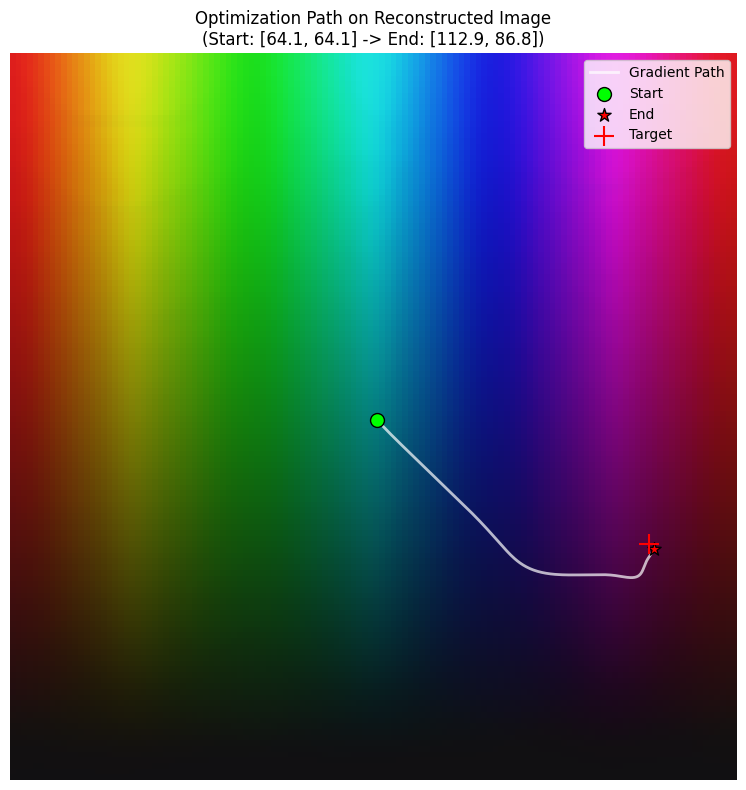

In [8]:
def convert_coo(x, resolution) :
    return (x+1)*(resolution-1)/2

print("Target: ", convert_coo(target_coo, resolution))
model_trained.eval()

# 2. Inference: Get the colors for all coordinates
with torch.no_grad():
    # Run the model on the full coordinate grid
    predicted_flat = model_trained(coords)
    
    # Move back to CPU and numpy for plotting
    # Reshape from (N, 3) -> (Height, Width, 3)
    # 'resolution' is 128 based on your earlier setup
    reconstructed_img = predicted_flat.reshape(resolution, resolution, 3).cpu().numpy()


path_array = convert_coo(path, resolution)
x_coords = path_array[:, 0]
y_coords = path_array[:, 1]

plt.figure(figsize=(8, 8))
plt.imshow(reconstructed_img)

plt.plot(x_coords, y_coords, color='white', linewidth=2, alpha=0.7, label='Gradient Path')

plt.scatter(x_coords[0], y_coords[0], color='lime', s=100, edgecolors='black', label='Start', zorder=5)
plt.scatter(x_coords[-1], y_coords[-1], color='red', marker='*', s=100, edgecolors='black', label='End', zorder=5)

plt.scatter(int(convert_coo(target_coo[0], resolution)), int(convert_coo(target_coo[1], resolution)), color='red', marker='+', s=200, label='Target', zorder=5)

plt.title(f"Optimization Path on Reconstructed Image\n(Start: [{x_coords[0]:.1f}, {y_coords[0]:.1f}] -> End: [{x_coords[-1]:.1f}, {y_coords[-1]:.1f}])")
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

## Task 2:
Patch Localization via Inversion on a Trained (Frozen) Neural Field

The goal of this task is to determine where a given image patch (a small region) is located within the coordinate space of a trained neural field. Unlike Task 1, which inverts a single (x, y) coordinate to find a target color, here we invert an entire **patch**: we optimize its **center** (cx, cy) and **scale** (sx, sy) so that the neural field, sampled over the corresponding grid of coordinates, reproduces the target patch as accurately as possible.

Step-by-step procedure:

1. Train (or load) a neural field model (e.g., SIREN) on a full image and freeze its parameters.
   - Easy: use `map-saturation.png` and its corresponding patch `map-saturation-patch.png`.
   - Medium: use `lego-bricks.png` and `lego-bricks-patch.png`.
   - Difficult: use `cats.jpeg` and `cats-patch.jpeg`.
   (You may want to adjust the neural field's parameters accordingly.)

2. Load a **target patch**—a small crop from an image (e.g., from a .jpeg file such as `lego-bricks-patch.jpeg`). This patch is the pattern you want to localize within the neural field’s coordinate space.

3. Parameterize the patch location using a **center** (cx, cy) and **scale** (sx, sy), each in the normalized range [-1, 1]. Implement a differentiable function that, given (cx, cy, sx, sy), produces the grid of (x, y) coordinates corresponding to the patch (for example, a local grid in [-1, 1] that is scaled and shifted by the center and scale).

4. Initialize learnable parameters for the patch (such as center and log-scale), and set up an optimizer that updates only these parameters while the neural field remains frozen.

5. In the optimization loop:
   - Consider different loss (e.g., MSE, or a perceptual loss such as VGG, or another suitable loss), compare them.

6. Visualize the results:
   - Plot the loss over iterations.
   - Show the target patch alongside the recovered patch (the patch sampled from the field at the optimized location).
   - Overlay the recovered patch location (for example, as a bounding box) on the full image to show where the patch was found.

7. You should consider trying different random initializations for (cx, cy, sx, sy), as the optimization problem is highly non-convex in some cases. 
Discuss whether the optimization converges to the same or to different locations.

In [9]:
patch_path = "lego-bricks-patch.jpeg"
image_path = "lego-bricks.jpeg"

resolution = 256

if patch_path is not None:
    patch_np = load_image(patch_path, resize=(resolution, resolution))
else:
    patch_np = generate_synthetic_image(resolution)

target_patch_tensor = torch.from_numpy(patch_np).reshape(-1, 3).to(device)


if image_path is not None:
    img_np = load_image(image_path, resize=(resolution, resolution))
else:
    img_np = generate_synthetic_image(resolution)

coords, colors = prepare_dataset(img_np)
print(f"Dataset: {coords.shape[0]} samples, coordinate tensor shape {coords.shape}, color tensor shape {colors.shape}")


model = SIREN(in_dim = 2, hidden_dim=hidden_dim_siren, num_layers=num_layers_siren,
              out_dim=3, omega_0=omega_0)
model = model.to(device)

model_trained, history = train_model(model, coords, colors,num_iters=1000, loss_type="mse", lr=1e-4, log_every=500)

Dataset: 65536 samples, coordinate tensor shape torch.Size([65536, 2]), color tensor shape torch.Size([65536, 3])
Epoch:  500
Epoch:  1000


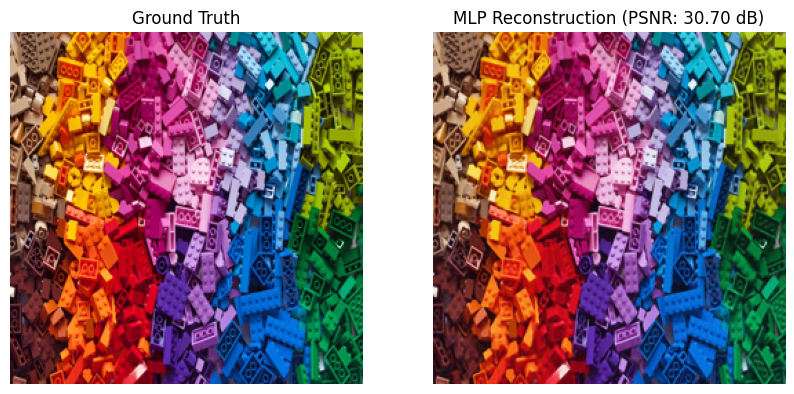

In [10]:
model_trained.eval()

# 2. Inference: Get the colors for all coordinates
with torch.no_grad():
    # Run the model on the full coordinate grid
    predicted_flat = model_trained(coords)
    
    # Move back to CPU and numpy for plotting
    # Reshape from (N, 3) -> (Height, Width, 3)
    # 'resolution' is 128 based on your earlier setup
    reconstructed_img = predicted_flat.reshape(resolution, resolution, 3).cpu().numpy()

plt.figure(figsize=(10, 5))

# Plot Original (Ground Truth)
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Ground Truth")
plt.axis("off")

# Plot Reconstruction
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img)
plt.title(f"MLP Reconstruction (PSNR: {history['psnr'][-1]:.2f} dB)")
plt.axis("off")

plt.show()

In [11]:
import torchvision.models as models
import torchvision.transforms as transforms

class VGGLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        # Load VGG16 pretrained on ImageNet
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features
        
        # We generally slice the network to capture mid-level features (e.g., up to ReLU3_3)
        # Index 16 in VGG16 features usually corresponds to the block after ReLU3_3
        self.slice = vgg[:16].to(device).eval()
        
        # Freeze parameters (we don't train VGG)
        for param in self.slice.parameters():
            param.requires_grad = False
            
        # VGG requires specific normalization
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1))
        
        self.mse = nn.MSELoss()

    def forward(self, input_img, target_img):
        # 1. Normalize inputs (assuming inputs are in [0, 1])
        input_norm = (input_img - self.mean) / self.std
        target_norm = (target_img - self.mean) / self.std
        
        # 2. Extract features
        input_feats = self.slice(input_norm)
        target_feats = self.slice(target_norm)
        
        # 3. Compute MSE between features
        return self.mse(input_feats, target_feats)

In [12]:
import torch
import torch.nn as nn

class CIELABLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def rgb_to_xyz(self, image):
        # RGB to XYZ conversion matrices (Observer = 2°, Illuminant = D65)
        # Assuming image is in [0, 1]
        
        # Gamma correction removal (linearization)
        mask = image > 0.04045
        image = torch.where(mask, torch.pow((image + 0.055) / 1.055, 2.4), image / 12.92)
        
        r, g, b = image[:, 0, ...], image[:, 1, ...], image[:, 2, ...]
        
        x = 0.4124564 * r + 0.3575761 * g + 0.1804375 * b
        y = 0.2126729 * r + 0.7151522 * g + 0.0721750 * b
        z = 0.0193339 * r + 0.1191920 * g + 0.9503041 * b
        
        return torch.stack((x, y, z), dim=1)

    def xyz_to_lab(self, xyz):
        # D65 white point reference
        ref_x, ref_y, ref_z = 95.047, 100.000, 108.883
        
        x = xyz[:, 0, ...] / (ref_x / 100)
        y = xyz[:, 1, ...] / (ref_y / 100)
        z = xyz[:, 2, ...] / (ref_z / 100)
        
        mask = x > 0.008856
        fx = torch.where(mask, torch.pow(x, 1/3), 7.787 * x + 16/116)
        
        mask = y > 0.008856
        fy = torch.where(mask, torch.pow(y, 1/3), 7.787 * y + 16/116)
        
        mask = z > 0.008856
        fz = torch.where(mask, torch.pow(z, 1/3), 7.787 * z + 16/116)
        
        l = 116 * fy - 16
        a = 500 * (fx - fy)
        b = 200 * (fy - fz)
        
        return torch.stack((l, a, b), dim=1)

    def forward(self, pred, target):
        # 1. Convert RGB to LAB
        # pred and target shape: (Batch, 3, Height, Width) or (N, 3)
        # If flat (N, 3), unsqueeze first
        is_flat = pred.dim() == 2
        if is_flat:
            pred = pred.view(1, -1, 3).permute(0, 2, 1) # Treat as 1D image
            target = target.view(1, -1, 3).permute(0, 2, 1)
        
        pred_lab = self.xyz_to_lab(self.rgb_to_xyz(pred))
        target_lab = self.xyz_to_lab(self.rgb_to_xyz(target))
        
        # 2. Calculate Euclidean Distance in LAB space (Delta E)
        # We use smooth L1 or MSE on the LAB values
        loss = nn.functional.mse_loss(pred_lab, target_lab)
        
        return loss

In [13]:
import torchvision.transforms.functional as F_vis
def get_differentiable_grid(center, log_scale, resolution, device):
    """
    Generates a grid of coordinates transformed by center and scale.
    This is fully differentiable.
    """
    # Create a local grid from -1 to 1 (the local view of the camera/patch)
    # We use torch.linspace so gradients can theoretically flow if needed (though usually fixed)
    u = torch.linspace(-1.0, 1.0, resolution, device=device)
    v = torch.linspace(-1.0, 1.0, resolution, device=device)
    
    # Create meshgrid
    # indexing='xy' matches the convention of Width, Height usually
    grid_u, grid_v = torch.meshgrid(u, v, indexing='xy')
    
    # Stack to shape (N, 2)
    base_grid = torch.stack([grid_u, grid_v], dim=-1).reshape(-1, 2)
    
    # Apply Transformation:
    # Coords = Center + (Local_View * Scale)
    # Scale acts as "Zoom". Large scale = zoomed out. Small scale = zoomed in.
    transformed_grid = center + (base_grid * torch.exp(log_scale))
    
    return transformed_grid


#center = torch.tensor(np.random.rand(2)*2-1, dtype=torch.float32, device=device, requires_grad=True)
center = torch.tensor([0.0,0.0], dtype=torch.float32, device=device, requires_grad=True)
log_scale = torch.tensor([-0.2], dtype=torch.float32, device=device, requires_grad=True)

path=[]
patches = []
n_epochs = 500
criterion = nn.MSELoss()
criterion_color = CIELABLoss()

optimizer = optim.Adam([
    {'params': [center], 'lr': 0.05},
    {'params': [log_scale], 'lr': 0.02}
])

model_trained.eval()

for epoch in range(n_epochs) :
    optimizer.zero_grad()


    coords_input = get_differentiable_grid(center, log_scale, resolution, device)
    actual_grid = model_trained(coords_input)

    actual_img_formatted = actual_grid.view(1, resolution, resolution, 3).permute(0, 3, 1, 2)
    target_img_formatted = target_patch_tensor.view(1, resolution, resolution, 3).permute(0, 3, 1, 2)

    #loss = criterion_color(actual_img_formatted, target_img_formatted)

    loss = criterion(actual_grid, target_patch_tensor) + 0.05*torch.exp(log_scale)
    loss.backward()
    optimizer.step()

    current_state = np.concatenate([center.detach().cpu().numpy(), log_scale.detach().cpu().numpy()])
    path.append(current_state)
    patches.append(actual_grid.detach().reshape(resolution, resolution, 3).cpu().numpy())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.5f} | Center: {path[-1][:2]} | Scale: {path[-1][2]:.3f}")

path = np.array(path)
patches = np.array(patches)


Epoch 0: Loss 0.15714 | Center: [-0.05        0.04999999] | Scale: -0.220
Epoch 50: Loss 0.08125 | Center: [-0.17742462  0.3578282 ] | Scale: -1.078
Epoch 100: Loss 0.06241 | Center: [-0.17570774  0.30402315] | Scale: -1.326
Epoch 150: Loss 0.05989 | Center: [-0.1749854  0.3065391] | Scale: -1.357
Epoch 200: Loss 0.05987 | Center: [-0.17466828  0.30646595] | Scale: -1.358
Epoch 250: Loss 0.06022 | Center: [-0.17265256  0.30574232] | Scale: -1.358
Epoch 300: Loss 0.06020 | Center: [-0.17364329  0.30608463] | Scale: -1.355
Epoch 350: Loss 0.05999 | Center: [-0.17312106  0.3056525 ] | Scale: -1.359
Epoch 400: Loss 0.05989 | Center: [-0.17485833  0.30668423] | Scale: -1.356
Epoch 450: Loss 0.06004 | Center: [-0.17576656  0.30697992] | Scale: -1.357


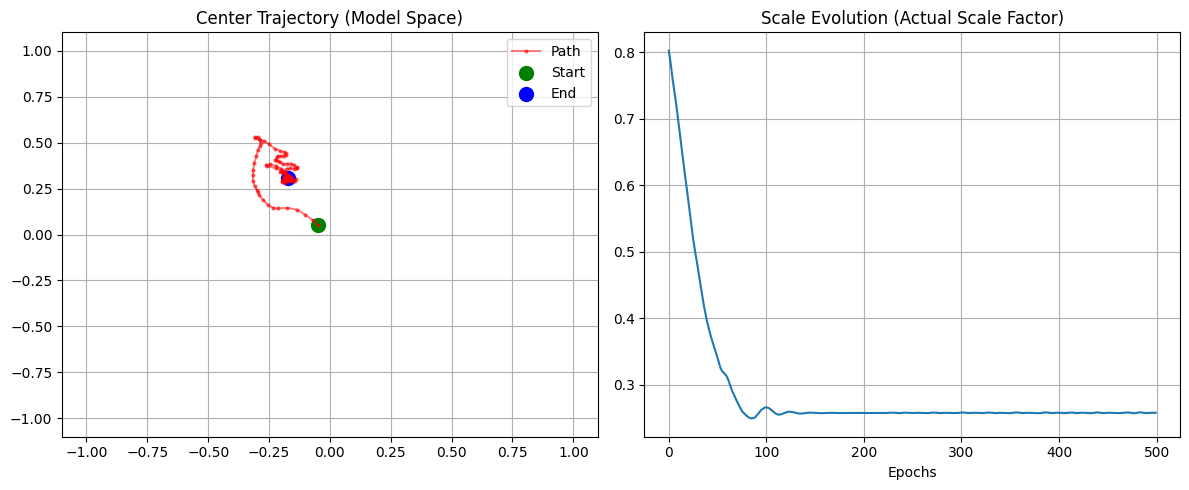

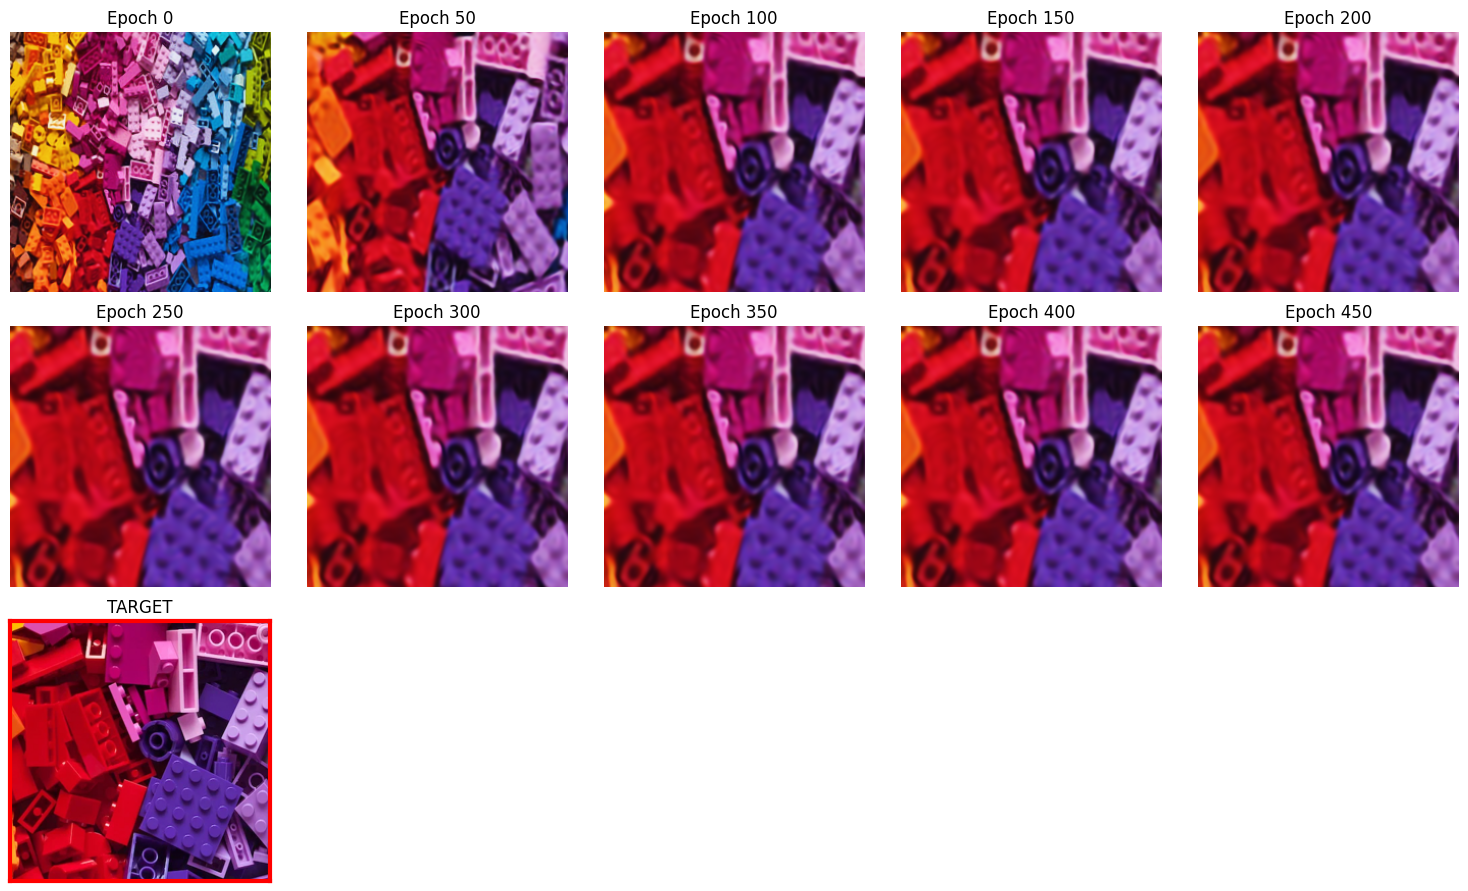

In [14]:
import math

# --- FIGURE 1: Optimization Metrics (Trajectory & Scale) ---
plt.figure(figsize=(12, 5))

# Plot 1: Trajectory
plt.subplot(1, 2, 1)
plt.plot(path[:, 0], path[:, 1], 'r-o', alpha=0.5, markersize=2, label='Path')
# Mark start and end
plt.scatter(path[0, 0], path[0, 1], c='green', s=100, label='Start')
plt.scatter(path[-1, 0], path[-1, 1], c='blue', s=100, label='End')
plt.title("Center Trajectory (Model Space)")
plt.legend()
plt.grid(True)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

# Plot 2: Scale
plt.subplot(1, 2, 2)
# We plot exp(log_scale) to see the actual zoom factor, not the log value
plt.plot(np.exp(path[:, 2])) 
plt.title("Scale Evolution (Actual Scale Factor)")
plt.xlabel("Epochs")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- FIGURE 2: Patch Evolution Grid ---

# 1. Determine which epochs to show
# We take a snapshot every 50 epochs
display_epochs = list(range(0, n_epochs, 50))

# 2. Calculate Grid Size
# +1 includes the Target Patch at the end
total_plots = len(display_epochs) + 1 
cols = 5
rows = math.ceil(total_plots / cols)

plt.figure(figsize=(15, 3 * rows))

# 3. Plot Intermediate Patches
for i, epoch_idx in enumerate(display_epochs):
    plt.subplot(rows, cols, i + 1)
    
    # Ensure we don't go out of bounds if patches array is slightly smaller
    if epoch_idx < len(patches):
        plt.imshow(patches[epoch_idx])
    
    plt.title(f"Epoch {epoch_idx}")
    plt.axis("off")

# 4. Plot Target Patch (The Goal)
plt.subplot(rows, cols, total_plots)
plt.imshow(patch_np)
plt.title("TARGET")
# Add a red border or distinct style to highlight it's the target
for spine in plt.gca().spines.values():
    spine.set_edgecolor('red')
    spine.set_linewidth(3)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

## Bonus:
Speed up: 
- Do we really need to compare all pixels?
- How to do coarse-to-fine? (can we move the patch?)
- How to decouple chromatic and the shape?

Try some and have fun ;)

## Task3 — GAN inversion + CLIP manipulation

This section gives a **minimal** example of:
1. **GAN inversion**: find a latent code $z$ such that the generator $G(z)$ reconstructs a target image (we optimize $z$ to minimize $\mathcal{L}(G(z), x)$).
2. **CLIP manipulation**: move $z$ so that $G(z)$ better matches a text prompt, by maximizing CLIP similarity between the generated image and the text.

We use **Hugging Face** models:
- **StyleGAN2** (face generator, 128×128): `hajar001/stylegan2-ffhq-128`
- **CLIP** (image–text similarity): `openai/clip-vit-base-patch32` via `transformers`

Dependencies: `pip install transformers huggingface_hub` (plus `torch`, `PIL`, `matplotlib` from the rest of the lab).

Objective: recover a StyleGAN2 latent that reproduces a target face, then steer the latent toward a text concept using CLIP.

What to do:
1. Load the pretrained StyleGAN2 generator and CLIP model; prepare a 128×128 target face (sampled or external).
2. Optimize a latent vector so the generated image matches the target in pixel space.
3. Starting from the inverted latent, run a second optimization that maximizes CLIP similarity to a chosen prompt while regularizing drift from the inversion.
4. Visualize target, inversion, and edited outputs side by side and describe how the prompt changes appearance.

Required packages: `torch`, `transformers`, `huggingface_hub`, `PIL`, `matplotlib`.


In [15]:
# Task3: GAN inversion + CLIP manipulation — load models from Hugging Face

import os
import sys
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

from huggingface_hub import hf_hub_download

style_gan_file = hf_hub_download(repo_id="hajar001/stylegan2-ffhq-128", filename="style_gan.py")
sys.path.insert(0, os.path.dirname(style_gan_file))
from style_gan import StyleGAN

gan = StyleGAN.from_pretrained("hajar001/stylegan2-ffhq-128").to(device).eval()
z_dim = 512

c:\Users\gabri\miniconda3\envs\ML\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


style_gan.py: 0.00B [00:00, ?B/s]

c:\Users\gabri\miniconda3\envs\ML\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gabri\.cache\huggingface\hub\models--hajar001--stylegan2-ffhq-128. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/75.7M [00:00<?, ?B/s]

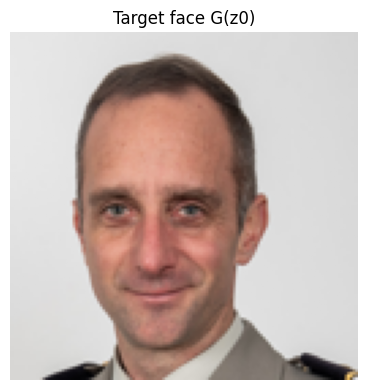

Target image shape: torch.Size([1, 3, 128, 128])


In [30]:
# Generate a target face from random z (we will invert this and then manipulate with CLIP)
z0 = torch.randn(1, z_dim, device=device)

with torch.no_grad():
    img_target, _ = gan(z0)
    # GAN output is in [-1, 1]; convert to [0, 1] for display and for inversion target
    img_target = (img_target + 1) / 2
    img_target = torch.clamp(img_target, 0, 1)



# or take directly from the repo
image_dir = "Thomas.Poswiat.jpg"
img_target = np.asarray(Image.open(image_dir).convert("RGB"), dtype=np.float32) / 255.0
# center crop and resize to 128x128
img_pil = Image.fromarray((np.clip(img_target, 0, 1) * 255).astype(np.uint8))
img_target = np.asarray(img_pil.resize((128, 128)), dtype=np.float32) / 255.0
# (H, W, C) -> (1, C, H, W) for PyTorch: transpose to (C, H, W) then add batch
img_target = torch.from_numpy(img_target.transpose(2, 0, 1)[np.newaxis, ...].copy()).float().to(device)

plt.figure(figsize=(4, 4))
plt.imshow(img_target[0].permute(1, 2, 0).cpu().numpy())
plt.title("Target face G(z0)")
plt.axis("off")
plt.tight_layout()
plt.show()
print("Target image shape:", img_target.shape)  # (1, 3, 128, 128)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\gabri\miniconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gabri\miniconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\gabri\miniconda3\envs\ML\lib\site-packages\lpips\weights\v0.1\vgg.pth
Epoch 0: Loss 0.60325
Epoch 50: Loss 0.43003
Epoch 100: Loss 0.30949
Epoch 150: Loss 0.22571
Epoch 200: Loss 0.16682
Epoch 250: Loss 0.13899
Epoch 300: Loss 0.12364
Epoch 350: Loss 0.11530
Epoch 400: Loss 0.10711
Epoch 450: Loss 0.10148


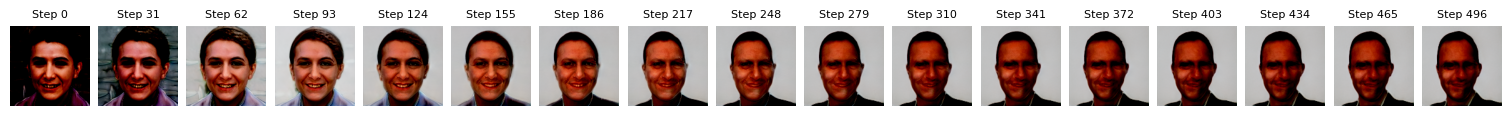

In [ ]:
# 3) GAN inversion: optimize latent z to match target
# Your code here
import lpips
lpips_loss = lpips.LPIPS(net='vgg').to(device)

target = img_target * 2 - 1
with torch.no_grad():
    z_samples = torch.randn(5000, z_dim, device=device)
    w_samples = gan.mapping(z_samples)
    w_avg = w_samples.mean(0, keepdim=True)

n_layers = w_avg.shape[1]
w_opt = w_avg.repeat(1, n_layers, 1).clone().detach().requires_grad_(True)

images=[]
losses = []
n_epochs = 500
mse = nn.MSELoss()

optimizer = optim.Adam([w_opt], lr=0.01)


for epoch in range(n_epochs) :
    optimizer.zero_grad()

    gen_img = gan.synthesis(w_opt)
    gen_img_01 = (gen_img + 1) / 2

    loss_perc = lpips_loss(gen_img, target).mean()
    loss_mse = mse(gen_img_01, img_target)
    loss_reg = (w_opt - w_avg).pow(2).mean()

    loss = 1.0 * loss_perc + 0.1 * loss_mse + 0.001 * loss_reg
    loss.backward()
    optimizer.step()

    if epoch % (n_epochs // 16) == 0:
        images.append(gen_img.detach().cpu())
    losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.5f}")

fig = plt.figure(figsize=(15, 4), constrained_layout=True)
gs = fig.add_gridspec(1, len(images))

for n, img_tensor in enumerate(images):
    f_ax = fig.add_subplot(gs[0, n])
    
    img_np = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    f_ax.imshow(np.clip(img_np,0,1))
    f_ax.axis("off")
    f_ax.set_title(f"Step {n*(n_epochs // 16)}", fontsize=8)

plt.show()

Epoch 0: Loss 0.78318
Epoch 50: Loss 0.68359
Epoch 100: Loss 0.63100
Epoch 150: Loss 0.60877
Epoch 200: Loss 0.59748
Epoch 250: Loss 0.59481
Epoch 300: Loss 0.58329
Epoch 350: Loss 0.58007
Epoch 400: Loss 0.57554
Epoch 450: Loss 0.56905
Epoch 500: Loss 0.56940
Epoch 550: Loss 0.55886
Epoch 600: Loss 0.55287
Epoch 650: Loss 0.54593
Epoch 700: Loss 0.54035
Epoch 750: Loss 0.53954
Epoch 800: Loss 0.53326
Epoch 850: Loss 0.53237
Epoch 900: Loss 0.52925
Epoch 950: Loss 0.52441


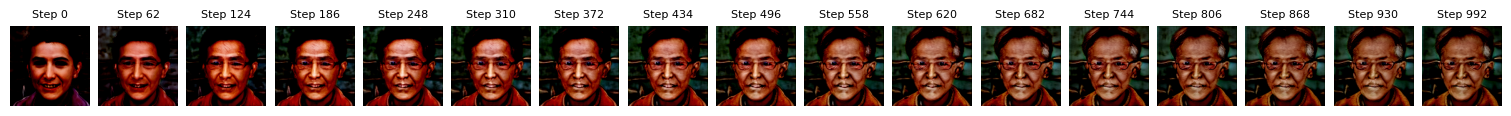

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_tile'

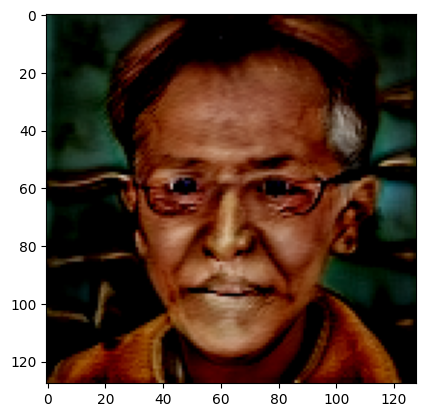

In [ ]:
# 4) CLIP manipulation: move z to match a text prompt
# Your code here
import torchvision.transforms as T
from torch.nn import functional as F

prompt = "A photo of an old man with glasses"
prompt_tokenized = clip_processor(text=[prompt], return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    target_text_features = clip_model.get_text_features(**prompt_tokenized)
    target_text_features = target_text_features / target_text_features.norm(dim=-1, keepdim=True)

with torch.no_grad():
    z_samples = torch.randn(5000, z_dim, device=device)
    w_samples = gan.mapping(z_samples)
    w_avg = w_samples.mean(0, keepdim=True)

n_layers = w_avg.shape[1]
w_opt = w_avg.repeat(1, n_layers, 1).clone().detach().requires_grad_(True)

images=[]
losses = []
n_epochs = 1000

optimizer = optim.Adam([w_opt], lr=0.01)

clip_mean = [0.48145466, 0.4578275, 0.40821073]
clip_std = [0.26862954, 0.26130258, 0.27577711]
clip_transform = T.Compose([
    T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
    T.Normalize(mean=clip_mean, std=clip_std)
])


for epoch in range(n_epochs) :
    optimizer.zero_grad()

    gen_img = gan.synthesis(w_opt)
    gen_img_01 = torch.clamp((gen_img + 1) / 2, 0, 1)

    img_processed = clip_transform(gen_img_01)
    image_features = clip_model.get_image_features(img_processed)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    similarity = torch.dot(image_features.flatten(), target_text_features.flatten())
    loss = 1 - similarity
    loss.backward()
    optimizer.step()

    if epoch % (n_epochs // 16) == 0:
        images.append(gen_img.detach().cpu())
    losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.5f}")

fig = plt.figure(figsize=(15, 4), constrained_layout=True)
gs = fig.add_gridspec(1, len(images))

for n, img_tensor in enumerate(images):
    f_ax = fig.add_subplot(gs[0, n])
    
    img_np = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    f_ax.imshow(np.clip(img_np,0,1))
    f_ax.axis("off")
    f_ax.set_title(f"Step {n*(n_epochs // 16)}", fontsize=8)

plt.show()

plt.imshow(np.clip(images[-1].squeeze(0).permute(1, 2, 0).numpy(),0,1))
plt.set_title("Final image")
plt.show()

## Discussion:
Are you satisfied with the results? If not, why? What potential methods could improve the results? (Just answer here; implementation is not required.)

Answer: